In [1]:
%cd ~/code/projects/nn-play/

import keras 
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam, Adadelta, RMSprop, SGD
from keras.layers import Input, Dense, Convolution2D, Deconvolution2D, MaxPooling2D,\
    UpSampling2D, Merge, LSTM, Flatten, ZeroPadding2D, Reshape, BatchNormalization, Dropout
from keras.layers.wrappers import TimeDistributed

from structured_container import DataContainer

import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/ira/code/projects/nn-play


Using TensorFlow backend.


In [2]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

In [3]:
IM_WIDTH = 28
IM_HEIGHT = 28
IM_CHANNELS = 1

SERIES_SHIFT = 1
EP_LEN = 100 - SERIES_SHIFT
BATCH_SIZE = 32

V_SIZE = 128

empty_model = True

In [4]:
input_im = Input(shape=(IM_WIDTH, IM_HEIGHT, IM_CHANNELS))
h = Convolution2D(16, 5, 5, subsample=(2,2), activation='relu', border_mode='same')(input_im)
h = Convolution2D(8, 3, 3, subsample=(2,2), activation='relu', border_mode='same')(h)
# h = Flatten()(h)
h = Reshape((392,))(h)
v = Dense(V_SIZE, activation='relu')(h)

enc = Model(input_im, v)
enc.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 14, 14, 16)    416         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 7, 7, 8)       1160        convolution2d_1[0][0]            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 392)           0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [5]:
input_v = Input(shape=(V_SIZE,))

h = Dense(8*7*7, activation='relu')(input_v)
h = Reshape((7,7,8))(h)
h = UpSampling2D((2,2))(h)
h = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(h)
h = UpSampling2D((2,2))(h)
output_im = Convolution2D(1, 5, 5, activation='sigmoid', border_mode='same')(h)

# output_im

dec = Model(input_v, output_im)
dec.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128)           0                                            
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 392)           50568       input_2[0][0]                    
____________________________________________________________________________________________________
reshape_2 (Reshape)              (None, 7, 7, 8)       0           dense_2[0][0]                    
____________________________________________________________________________________________________
upsampling2d_1 (UpSampling2D)    (None, 14, 14, 8)     0           reshape_2[0][0]                  
___________________________________________________________________________________________

In [6]:
input_im = Input(shape=(IM_WIDTH, IM_HEIGHT, IM_CHANNELS))
v = enc(input_im)
output_im = dec(v)

ae = Model(input_im, output_im)
ae.compile(optimizer=Adam(lr=0.0002), loss='mse')
ae.summary();

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 128)           51880       input_3[0][0]                    
____________________________________________________________________________________________________
model_2 (Model)                  (None, 28, 28, 1)     52137       model_1[1][0]                    
Total params: 104,017
Trainable params: 104,017
Non-trainable params: 0
____________________________________________________________________________________________________


In [7]:
input_ims = Input(shape=(EP_LEN-SERIES_SHIFT, IM_WIDTH, IM_HEIGHT, IM_CHANNELS))
in_vs = TimeDistributed(enc, input_shape=((EP_LEN-SERIES_SHIFT, IM_WIDTH, IM_HEIGHT, IM_CHANNELS)))(input_ims)

# lstm = LSTM(V_SIZE, input_shape=(EP_LEN, V_SIZE), return_sequences=True)
lstm = LSTM(V_SIZE, return_sequences=True)

out_vs = lstm(in_vs)
output_recons = TimeDistributed(dec, input_shape=((EP_LEN, V_SIZE)))(out_vs)

pred_ae = Model(input_ims, output_recons)
pred_ae.compile(optimizer=Adam(lr=0.001), loss='mse')
pred_ae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 98, 28, 28, 1) 0                                            
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (None, 98, 128)       51880       input_4[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 98, 128)       131584      timedistributed_1[0][0]          
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribut (None, 98, 28, 28, 1) 52137       lstm_1[0][0]                     
Total params: 235,601
Trainable params: 235,601
Non-trainable params: 0
___________________

In [8]:
if empty_model:
    fpath = 'models/pred_ae_single_trained_1.hdf5'
#     pred_ae.save_weights(fpath)
    pred_ae.load_weights(fpath)
    empty_model = False

In [9]:
input_im = Input(batch_shape=(1, IM_WIDTH, IM_HEIGHT, IM_CHANNELS))

in_v = enc(input_im)
in_v = Reshape((1,128))(in_v)
lstm_spare = LSTM(V_SIZE, stateful=True)
out_v = lstm_spare(in_v)

lstm_spare.set_weights(lstm.get_weights())

output_recon = dec(out_v)

stepper = Model(input_im, output_recon)
# stepper.compile(optimizer=Adam(lr=0.001), loss='mse')
stepper.summary() 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (1, 28, 28, 1)        0                                            
____________________________________________________________________________________________________
model_1 (Model)                  multiple              51880       input_5[0][0]                    
____________________________________________________________________________________________________
reshape_3 (Reshape)              (1, 1, 128)           0           model_1[2][0]                    
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (1, 128)              131584      reshape_3[0][0]                  
___________________________________________________________________________________________

In [10]:
images_train = DataContainer('data-balls/balls-train.pt', batch_size=32,
                          ep_len_read=EP_LEN)
images_valid = DataContainer('data-balls/balls-valid.pt', batch_size=32,
                          ep_len_read=EP_LEN)

In [15]:
images_train.populate_images()

In [196]:
stepper.reset_states()

In [11]:
x = images_train.get_batch_episodes()
i = 0

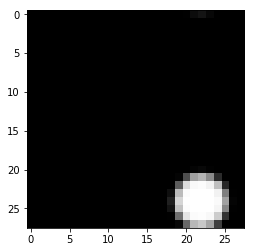

In [45]:
x_t = x[0, i,...]
i += 1
x_t = x_t.reshape((1, 28, 28, 1))
x_hat = stepper.predict(x_t*0)
plt.imshow(x[0,i,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)

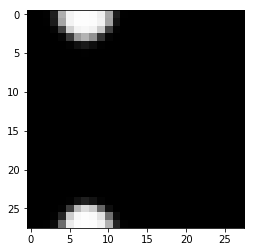

In [426]:
# for i in range(0):
x_hat = stepper.predict(x_t*0)
plt.imshow(x_hat[0,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)

In [47]:
out_tensor = stepper.output

In [179]:
out_tensor

<tf.Tensor 'Sigmoid_3:0' shape=(1, 28, 28, 1) dtype=float32>

In [490]:
lay  = pred_ae.layers[2]
lay

In [491]:
s = lay.states
s

[None, None]

In [183]:
s0.get_shape()

TensorShape([Dimension(1), Dimension(128)])

In [273]:
grads = K.gradients(out_tensor, s0)

In [274]:
dods = grads[0]

In [476]:
a = sess.run(dods, feed_dict={stepper.input:x_t*0})
a

array([[  0.00000000e+00,  -5.46425700e-01,  -5.27146319e-03,
          8.77525210e-02,   1.60584062e-01,  -1.63198137e+00,
          2.29710210e-02,   4.01731396e+00,   1.66253614e+00,
         -7.15473771e-01,  -1.22063747e-03,  -4.60186526e-02,
          7.81978071e-01,   6.40306680e-04,  -1.22061026e+00,
          5.04570901e-01,  -1.43467989e-02,   2.52453232e+00,
         -1.81063518e-01,   8.22171211e-01,   8.98437977e-01,
          6.60117745e-01,  -5.41800819e-02,  -3.42257466e-04,
         -7.74865091e-01,   1.32316642e-03,   1.48698080e+00,
         -9.93887782e-01,  -1.85599589e+00,  -9.89349842e-01,
         -2.41644084e-01,  -1.86248906e-06,   4.14768726e-01,
          0.00000000e+00,   5.59455335e-01,   2.52522022e-05,
          0.00000000e+00,   1.98935606e-02,   3.96935642e-02,
         -1.20027340e-03,  -1.35517776e-01,   1.98011056e-01,
          0.00000000e+00,  -2.45509744e-01,   2.58163810e-01,
          5.20618074e-03,  -3.53440195e-01,  -2.74039339e-03,
        

In [483]:
s0 = lay.states
s = sess.run(s0, feed_dict={stepper.input:x_t*0})
s

[array([[ -4.47716773e-01,   5.08837809e-04,  -1.57354716e-02,
          -2.59158999e-01,   2.48169545e-05,  -2.37570658e-01,
          -1.08590364e-01,  -4.58452012e-03,  -6.06298679e-03,
          -1.83983907e-01,   3.41405004e-01,  -3.99778374e-02,
           2.13363528e-01,  -9.10240412e-02,   1.18694626e-01,
           1.34986132e-01,   2.32483089e-01,  -3.91321518e-02,
           4.89945486e-02,   2.08822414e-01,  -1.90360378e-03,
          -5.37047312e-02,   2.86298692e-01,   4.41770315e-01,
          -4.23881449e-02,  -2.37282813e-01,   1.41622305e-01,
          -5.68910821e-07,  -1.29816783e-07,  -1.62114128e-01,
          -3.82624775e-01,   1.54165596e-01,  -4.08770479e-02,
          -0.00000000e+00,  -4.96477095e-22,   4.44632202e-01,
          -9.28596556e-02,  -2.02694699e-01,   1.76031962e-01,
          -1.13455117e-01,   1.59340113e-01,   7.90108666e-02,
          -6.49799407e-02,  -9.16097909e-02,  -1.23252213e-01,
           7.38312374e-04,   4.32301536e-02,  -2.182831